In [66]:
# import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
# Cross validation framework
def do_cross_validation(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('EN', ElasticNet()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('CART', DecisionTreeRegressor()))
    models.append(('SVR', SVR()))
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%s: %f (%f) r2: %f (%f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
    return results_rmse, results_r2, names

In [68]:
pisaTrain = pd.read_csv('pisa2009train.csv')
pisaTest = pd.read_csv('pisa2009test.csv')
print('Shape of training set: ',pisaTrain.shape)
print('Shape of test set: ', pisaTest.shape)

('Shape of training set: ', (3663, 24))
('Shape of test set: ', (1570, 24))


### Impute Missing Values

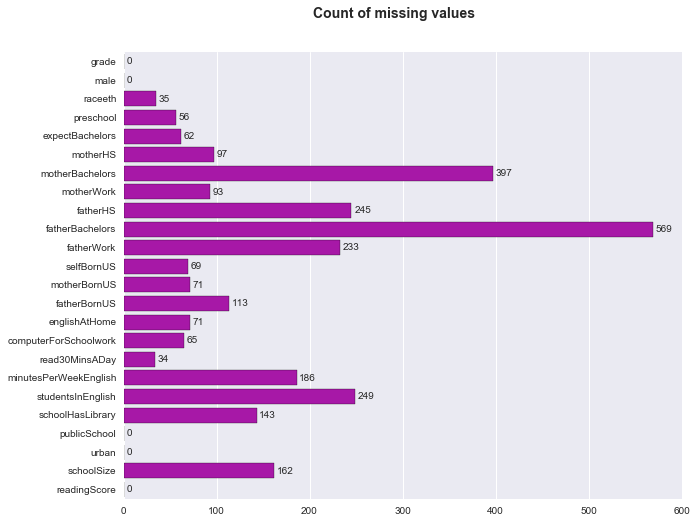

In [69]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Count of missing values', fontsize=14, fontweight='bold')
null_data = pisaTrain.isnull().sum()
ax = sns.barplot(x = null_data.values, y=null_data.index, color="m" )
i = 0
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + 0.5, null_data.values[i])
    i += 1

In [70]:
# For continuous variables replace the missing data with average of columns
pisaTrain['minutesPerWeekEnglish'].fillna(int(pisaTrain['minutesPerWeekEnglish'].mean()), inplace=True)
pisaTrain['studentsInEnglish'].fillna(int(pisaTrain['studentsInEnglish'].mean()), inplace=True)
pisaTrain['schoolSize'].fillna(int(pisaTrain['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisaTrain['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisaTrain = pisaTrain.apply(lambda x:x.fillna(0.5))

### Encode categorical values

In [71]:
raceeth = pd.get_dummies(pisaTrain['raceeth'], 'raceeth')
pisaTrain = pd.concat([pisaTrain, raceeth], axis=1)
pisaTrain = pisaTrain.drop('raceeth', axis=1)

### Evaluate Algorithms: Baseline

In [72]:
y_train = pisaTrain['readingScore'].values
pisaTrain = pisaTrain.drop('readingScore', axis=1)

In [73]:
X_train = pisaTrain.values
rmse, r2, names = do_cross_validation(X_train, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 107.048533 (2.085656) r2: -0.275294 (0.101883)
SVR: 94.954571 (1.935298) r2: 0.008209 (0.005552)


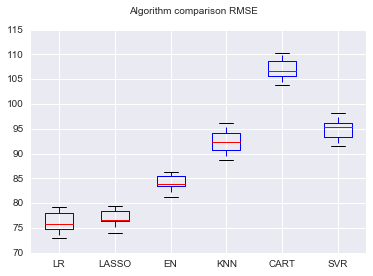

In [74]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm comparison RMSE')
ax = fig.add_subplot(111)
plt.boxplot(rmse)
ax.set_xticklabels(names)
plt.show()

## Data Preparation and Modeling Pipeline

In [75]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [76]:
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('LR', LinearRegression()))
model = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=7)
results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
print(results.mean())

76.2263128012


## Feature Extraction and Modeling Pipeline

In [77]:


# create feature union
features = []
features.append(('pca', PCA(n_components=12)))
features.append(('select_best', SelectKBest(score_func=f_regression, k=16)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('LR', LinearRegression()))

model = Pipeline(estimators)

# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7)
results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold,  scoring = 'neg_mean_squared_error'))
print(results.mean())



76.2700791691
